# Importaciones

In [182]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [183]:
df_pizzas = pd.read_csv(r'Datawarehouse\pizzas_normales.csv')

df_especiales = pd.read_csv(r'Datawarehouse\pizzas_especiales.csv')

In [184]:
df_pizzas.head()

,codigo,nombre,fecha,mes,unidades_gr,unidades_ch,venta_gr,venta_ch,unidades_total,venta_total
0,350,Mozzarella,2023-01-01,January,276.0,33.0,1832032.51,197400.0,309.0,2029432.51
1,350,Mozzarella,2023-02-01,February,331.0,36.5,2460739.91,221000.0,367.5,2681739.91
2,350,Mozzarella,2023-03-01,March,209.0,38.0,1870000.00,266000.0,247.0,2136000.00
3,350,Mozzarella,2023-04-01,April,154.0,28.0,1364880.57,189000.0,182.0,1553880.57
4,350,Mozzarella,2023-05-01,May,240.5,22.5,2063533.62,168250.0,263.0,2231783.62


# Regresion Lineal

In [185]:
unidades_totales_mes = df_pizzas.groupby('mes')['unidades_total'].sum().reset_index()

# Asignar un número a cada mes
meses_numeros = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5}
unidades_totales_mes['mes_num'] = unidades_totales_mes['mes'].map(meses_numeros)
unidades_totales_mes

,mes,unidades_total,mes_num
0,April,1530.5,4
1,February,2177.0,2
2,January,2352.0,1
3,March,1724.5,3
4,May,1527.0,5


In [186]:
# Seleccionar las características (X) y la variable objetivo (y)
X = unidades_totales_mes[['mes_num']]
y = unidades_totales_mes['unidades_total']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)


In [187]:
# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 53490.916666666635
Root Mean Squared Error: 231.28103395364403


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


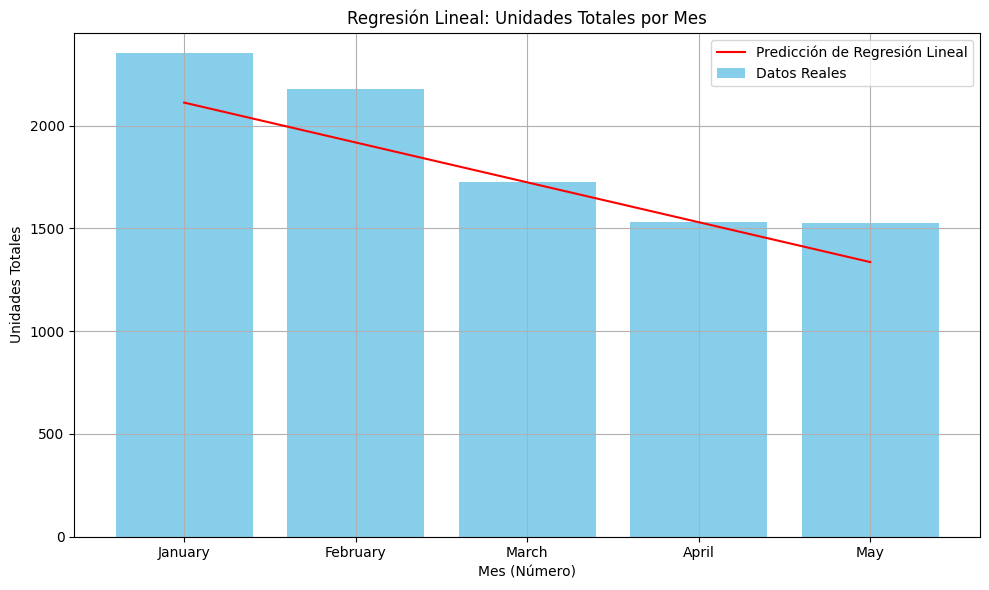

In [188]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.bar(X['mes_num'], y, color='skyblue', label='Datos Reales')

# Crear un conjunto de datos para la línea de predicción
X_plot = np.linspace(1, 5, 100).reshape(-1, 1)
y_plot = model.predict(X_plot)
plt.plot(X_plot, y_plot, color='red', label='Predicción de Regresión Lineal')

# Personalizar el gráfico
plt.xlabel('Mes (Número)')
plt.ylabel('Unidades Totales')
plt.title('Regresión Lineal: Unidades Totales por Mes')
plt.ylim(0, max(y) + 100)  # Establecer el límite inferior del eje y a 0 y el superior a un poco más del valor máximo de y
plt.xticks(ticks=range(1, 6), labels=['January', 'February', 'March', 'April', 'May'])
plt.legend()

# Agregar una cuadrícula
plt.grid(True)

plt.tight_layout()
plt.show()

# Arima

In [189]:
# Asignar un número a cada mes
meses_numeros = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5}
df_pizzas['mes_num'] = df_pizzas['mes'].map(meses_numeros)

# Sumar las unidades totales por mes
unidades_totales_mes = df_pizzas.groupby('mes_num')['unidades_total'].sum().reset_index()
unidades_totales_mes.sort_values('mes_num', inplace=True)
unidades_totales_mes.set_index('mes_num', inplace=True)
unidades_totales_mes

,unidades_total
mes_num,
1,2352.0
2,2177.0
3,1724.5
4,1530.5
5,1527.0


In [190]:
# Preparar los datos para el modelo ARIMA
y = unidades_totales_mes['unidades_total']

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(y) * 0.7)
train, test = y[0:train_size], y[train_size:]

# Ajustar el modelo ARIMA (usando una configuración de p=1, d=1, q=1 como ejemplo)
model = ARIMA(train, order=(1, 0, 0))
model_fit = model.fit()

# Hacer predicciones
predictions = model_fit.forecast(steps=len(test))

C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\l

In [191]:
# Evaluar el modelo
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')


Mean Squared Error: 332652.1865789844
Root Mean Squared Error: 576.7600771369187


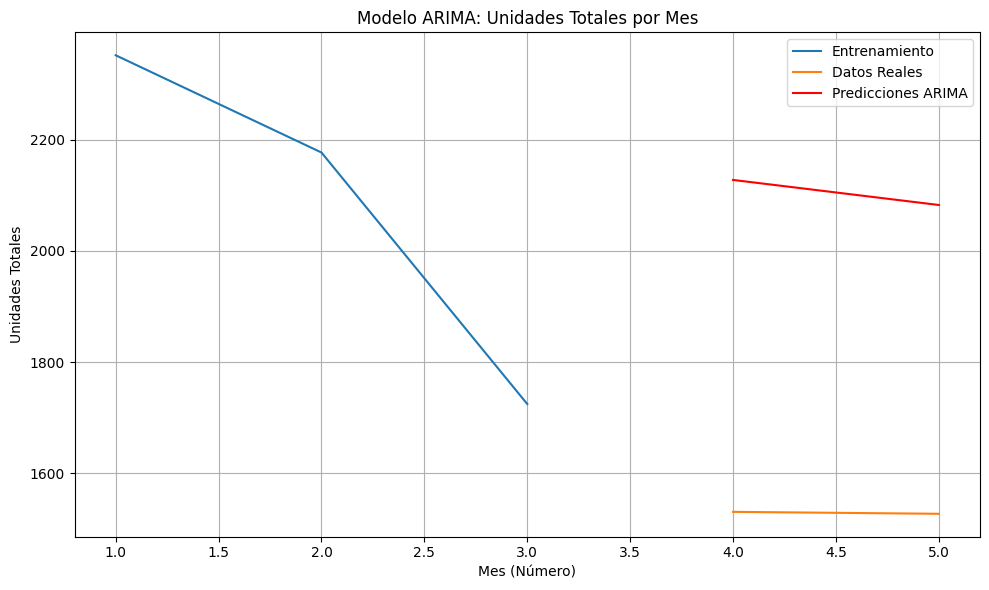

In [192]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Datos Reales')
plt.plot(test.index, predictions, color='red', label='Predicciones ARIMA')

# Personalizar el gráfico
plt.xlabel('Mes (Número)')
plt.ylabel('Unidades Totales')
plt.title('Modelo ARIMA: Unidades Totales por Mes')
plt.legend()

# Agregar una cuadrícula
plt.grid(True)

plt.tight_layout()
plt.show()